# 감성 분석

- 분류 모델의 가장 대표적인 활용 방법 중 하나
- 텍스트 데이터를 긍정 또는 부정으로 나누어 분류하는 것

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from selenium import webdriver
from bs4 import BeautifulSoup
import re
import time
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import requests
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import sys
sys.version
from konlpy.tag import Okt

In [2]:
okt = Okt()

# 맛집 상세페이지 url 정보 크롤링

In [3]:
# 크롤링할 주소
url = "https://map.kakao.com/"

In [4]:
driver = webdriver.Chrome(service = webdriver.ChromeService("chromedriver.exe")) # service는 chromedriver.exe의 위치를 나타냄

# 카카오지도 접속
driver.get(url)

# 검색창에 검색어 입력
searchbox = driver.find_element(By.CSS_SELECTOR, "input.query")
searchbox.send_keys("신촌 맛집")

# 엔터 눌러서 결과 받아오기
searchbox.send_keys(Keys.ENTER)

# 검색 결과를 가져올 시간 대기
time.sleep(1)

# html 정보 파싱
soup = BeautifulSoup(driver.page_source, "lxml")
moreviews = soup.select("a.moreview")

# 크롤링할 페이지 리스트 생성
page_urls = [i.get("href") for i in moreviews] #################################
driver.close()

In [5]:
page_urls

['https://place.map.kakao.com/1165755646',
 'https://place.map.kakao.com/15937430',
 'https://place.map.kakao.com/27144649',
 'https://place.map.kakao.com/26976526',
 'https://place.map.kakao.com/17505297',
 'https://place.map.kakao.com/21395214',
 'https://place.map.kakao.com/1011256721',
 'https://place.map.kakao.com/26522526',
 'https://place.map.kakao.com/1705674698',
 'https://place.map.kakao.com/7892863',
 'https://place.map.kakao.com/10621045',
 'https://place.map.kakao.com/18826661',
 'https://place.map.kakao.com/15847929',
 'https://place.map.kakao.com/1025832828',
 'https://place.map.kakao.com/1227036908']

# 상세 페이지에서 리뷰 크롤링

In [6]:
res = requests.get("https://place.map.kakao.com/main/v/1165755646")

In [7]:
data = res.json()

In [8]:
data.keys()

dict_keys(['isMapUser', 'isExist', 'basicInfo', 's2graph', 'blogReview', 'comment', 'findway', 'placeOwnerInfos', 'menuInfo', 'photo'])

In [9]:
# 별점
data["comment"]["list"][1]["point"]

5

In [10]:
# 후기
data["comment"]["list"][1]["contents"]

'마늘빵 안 좋아하는데 여기 진짜 마싯네요.. ㅠ\n카푸치노 빵피도 식감이 귀엽고 부담없이 술술 들어가는 맛.ᐟ 친절하시구 좋아요 또 사러 갈게요 ㅎ'

In [11]:
len(data["comment"]["list"])

3

In [12]:
data["comment"]["list"][-1]["commentid"]

'8684991'

In [13]:
stars = []
reviews = []

# 댓글 정보 url
base_url = "https://place.map.kakao.com/commentlist/v/"

# 위에서 수집한 15개 가게에 대해서 수집
for url in page_urls:
    last_id = ""
    
    # 5번 더보기 수행
    for _ in range(5):
        res = requests.get(base_url + url[28:] +"/" + last_id)
        data = res.json()
        
        if "comment" not in data: #############################################
            continue
            
        # 별점, 리뷰 수집
        for review in data["comment"]["list"]:
            stars.append(review["point"])
            reviews.append(review["contents"])
            
        # 더보기 시에 사용할 마지막 id
        last_id = review["commentid"]
        time.sleep(1)

In [14]:
len(reviews)

350

In [15]:
len(stars)

350

In [16]:
df = pd.DataFrame({"score" : stars, "review" : reviews})

In [17]:
df.head()

,score,review
0,5,
1,5,마늘빵 안 좋아하는데 여기 진짜 마싯네요.. ㅠ\n카푸치노 빵피도 식감이 귀엽고 부...
2,3,빵이 심각하게 달다\n한 번 먹어 본 걸로 끝..다시 갈 일은 없을 듯\n비효율적인...
3,5,시식도만땅으로주시고 웨이팅이 가게가협소해서그런지 오픈런하고와도 좀있는점이아쉽다면아쉽...
4,3,빵이 너무 너무 달아요&hellip; 모든 빵에 설탕 코팅이 되어있더라고요.\n먹다...


In [18]:
# 4점 이상 리뷰는 긍정 리뷰, 3점 이하는 부정 리뷰로 평가
df["y"] = df["score"].map(lambda x: 1 if x > 3 else 0)

In [19]:
df.head()

,score,review,y
0,5,,1
1,5,마늘빵 안 좋아하는데 여기 진짜 마싯네요.. ㅠ\n카푸치노 빵피도 식감이 귀엽고 부...,1
2,3,빵이 심각하게 달다\n한 번 먹어 본 걸로 끝..다시 갈 일은 없을 듯\n비효율적인...,0
3,5,시식도만땅으로주시고 웨이팅이 가게가협소해서그런지 오픈런하고와도 좀있는점이아쉽다면아쉽...,1
4,3,빵이 너무 너무 달아요&hellip; 모든 빵에 설탕 코팅이 되어있더라고요.\n먹다...,0


In [20]:
# 레이블값 비율 확인
df["y"].value_counts()

1    218
0    132
Name: y, dtype: int64

# 텍스트 전처리

## 한글 추출

In [21]:
########################################################
def text_cleaning(text:str) -> str:
    '''
    텍스트 정제 함수.
    한글 이외의 문자는 전부 제거
    '''
    # 한글 이외의 문자들 추출
    han = re.compile("[^ ㄱ-ㅣ가-힣]+")###############ㄱ-ㅣ : ㄱ~ㅣ, 가-힣 : 가~힣
    
    # 한글 이외의 문자들 제거
    text = han.sub(" ", text)
    
    return text

In [22]:
text_cleaning("마늘빵 안 좋아하는데 여기 진짜 마싯네요.. ㅠ\n카푸치노 빵피도 식감이 귀엽고bbb")

'마늘빵 안 좋아하는데 여기 진짜 마싯네요  ㅠ 카푸치노 빵피도 식감이 귀엽고 '

In [23]:
df["ko_text"] = df["review"].map(text_cleaning)

In [24]:
df.head()

,score,review,y,ko_text
0,5,,1,
1,5,마늘빵 안 좋아하는데 여기 진짜 마싯네요.. ㅠ\n카푸치노 빵피도 식감이 귀엽고 부...,1,마늘빵 안 좋아하는데 여기 진짜 마싯네요 ㅠ 카푸치노 빵피도 식감이 귀엽고 부담없...
2,3,빵이 심각하게 달다\n한 번 먹어 본 걸로 끝..다시 갈 일은 없을 듯\n비효율적인...,0,빵이 심각하게 달다 한 번 먹어 본 걸로 끝 다시 갈 일은 없을 듯 비효율적인 웨이...
3,5,시식도만땅으로주시고 웨이팅이 가게가협소해서그런지 오픈런하고와도 좀있는점이아쉽다면아쉽...,1,시식도만땅으로주시고 웨이팅이 가게가협소해서그런지 오픈런하고와도 좀있는점이아쉽다면아쉽...
4,3,빵이 너무 너무 달아요&hellip; 모든 빵에 설탕 코팅이 되어있더라고요.\n먹다...,0,빵이 너무 너무 달아요 모든 빵에 설탕 코팅이 되어있더라고요 먹다보니 단맛에 질려...


In [25]:
df.shape

(350, 4)

In [26]:
df = df[df["ko_text"].str.len() > 0]

In [27]:
df.head()

,score,review,y,ko_text
1,5,마늘빵 안 좋아하는데 여기 진짜 마싯네요.. ㅠ\n카푸치노 빵피도 식감이 귀엽고 부...,1,마늘빵 안 좋아하는데 여기 진짜 마싯네요 ㅠ 카푸치노 빵피도 식감이 귀엽고 부담없...
2,3,빵이 심각하게 달다\n한 번 먹어 본 걸로 끝..다시 갈 일은 없을 듯\n비효율적인...,0,빵이 심각하게 달다 한 번 먹어 본 걸로 끝 다시 갈 일은 없을 듯 비효율적인 웨이...
3,5,시식도만땅으로주시고 웨이팅이 가게가협소해서그런지 오픈런하고와도 좀있는점이아쉽다면아쉽...,1,시식도만땅으로주시고 웨이팅이 가게가협소해서그런지 오픈런하고와도 좀있는점이아쉽다면아쉽...
4,3,빵이 너무 너무 달아요&hellip; 모든 빵에 설탕 코팅이 되어있더라고요.\n먹다...,0,빵이 너무 너무 달아요 모든 빵에 설탕 코팅이 되어있더라고요 먹다보니 단맛에 질려...
5,5,가격이 싸진않지만 호두들어가있는빵이 개 맛도리네요 ㄷㄷㄷ \n마늘바게트는 소스가 많...,1,가격이 싸진않지만 호두들어가있는빵이 개 맛도리네요 ㄷㄷㄷ 마늘바게트는 소스가 많아...


In [28]:
df.shape

(272, 4)

## 형태소 추출

In [29]:
def get_pos(x:str) -> list:
    '''
    텍스트 데이터에서 형태소 추출하는 함수
    '''
    okt = Okt()
    pos = okt.pos(x)
    pos = [f"{word}/{tag}" for word, tag in pos]
    return pos

In [30]:
# 테스트
result = get_pos(df["ko_text"].values[0])
result

['마늘빵/Noun',
 '안/Noun',
 '좋아하는데/Adjective',
 '여기/Noun',
 '진짜/Noun',
 '마싯네요/Verb',
 'ㅠ/KoreanParticle',
 '카푸치노/Noun',
 '빵피/Noun',
 '도/Josa',
 '식감/Noun',
 '이/Josa',
 '귀엽고/Adjective',
 '부담/Noun',
 '없이/Adverb',
 '술술/Noun',
 '들어가는/Verb',
 '맛/Noun',
 '친절하시구/Adjective',
 '좋아요/Adjective',
 '또/Noun',
 '사러/Verb',
 '갈게요/Verb',
 'ㅎ/KoreanParticle']

## 텍스트 임베딩

- 텍스트 데이터를 연산이 가능한 피처로 변환

### TF-IDF(Term Frequency-Inverse Document Frequency)

- 단어의 빈도와 역 문서 빈도를 사용하여 각 단어들의 중요도를 가중치로 주는 방법
- TF : 1개의 문서 내에서 특정 단어의 등장 빈도
- DF : 특정 단어가 등장한 문서의 수
- IDF : DF에 반비례하는 수
- 다른 문서들에서는 많이 등장하지 않았지만 현재 문서에서는 많이 등장하는 단어를 의미
    - 해당 단어가 현재 문서에서 얼마나 중요한지를 계산하는 방법

In [31]:
x = df["ko_text"]
y = df["y"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=4)

In [32]:
len(x_train)

190

In [33]:
x_train

158                                               나쁘지 않음
38     형제갈비 주차발렛하시는분 다시모집하셔야할듯  고객도 못알아보고 도로피해서 가게앞 지...
147    혼자갔는데 사장이 만석도 아닌데 만석이라고 넘 퉁명스럽게 밖에서 기다리라함  날씨추...
171                                     먹자마자 눈이 팍  트이는 맛
337    분위기 좋고 수다 떨기 좋은 파스타집  처음에 입구에 들어서면 사장님께서 엄청 친절...
                             ...                        
69                              가성비로 따지면 훌륭하지만 맛있지는 않아요 
110                                     맛있고 회전율 빨라서 좋아요 
252    짜장 짬뽕이 다른데 보다 약간 비싼데 개인적으로는 비싼 값 한다는 느낌  건물 자체...
222    홍면이랑 유린기 시켜서 먹었는데 웨이팅 해서 먹을 정도의 특별한 맛은 아니었어요  ...
156                            메뉴는 다양해서 좋음 하지만 맛은 그냥 보통임
Name: ko_text, Length: 190, dtype: object

In [34]:
tfidf = TfidfVectorizer()
tf_train = tfidf.fit_transform(x_train)
tf_test = tfidf.transform(x_test)

In [35]:
tf_train.shape

(190, 1960)

In [36]:
tf_train

<190x1960 sparse matrix of type '<class 'numpy.float64'>'
	with 2583 stored elements in Compressed Sparse Row format>

# 모델 훈련

In [37]:
logi = LogisticRegression()
logi.fit(tf_train, y_train)

LogisticRegression()

In [38]:
pred = logi.predict(tf_test)
proba = logi.predict_proba(tf_test)[:, 1]

In [39]:
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))

0.6707317073170732
0.7969924812030076


In [40]:
comat = confusion_matrix(y_test, pred)
print(comat)

[[ 2 26]
 [ 1 53]]


In [41]:
pd.DataFrame({"text" : x_test, "pred" : pred})

,text,pred
269,간짜장은 맛있게 먹었는데 짬뽕은 개인적으로 아쉬웠어요,1
44,비싼 데다 팁까지 강요함,1
207,미슐랭 인증이라고 써있었는데 한번 해보자는 마음으로 갔어요 비오는 날 줄 서는 것도...,1
155,펌킨파이가 젤 맛있어요 근데 사람 너어무 많고 정신없어서 무조건 포장해감 늦게가면 품절,1
131,맛있어요 부추 반찬 무한리필 굿,1
...,...,...
331,소개팅 하기 좋은 신촌 맛집,1
271,양은적지만 맛이좋네,1
262,매운홍합 최고,1
231,짬뽕이랑 불밥이 맛남 짬뽕은 진하기보단 시원한 느낌 전에 쓰던 면은 조금 더 두...,1


# 모델 최적화

In [42]:
df["y"].value_counts()

1    165
0    107
Name: y, dtype: int64

In [43]:
# 1 : 1 비율로 랜덤 샘플링 수행
pos_idx = df[df["y"] == 1].sample(106, random_state = 4).index.tolist()
neg_idx = df[df["y"] == 0].index.tolist()

In [44]:
random_idx = pos_idx + neg_idx
sample_x = x[random_idx]
sample_y = df["y"][random_idx]

x_train, x_test, y_train, y_test =train_test_split(sample_x, sample_y, test_size=0.3, stratify=sample_y, random_state=4)

tfidf = TfidfVectorizer()
tf_train = tfidf.fit_transform(x_train)
tf_test = tfidf.transform(x_test)

In [45]:
len(sample_x)

213

In [46]:
logi = LogisticRegression()
logi.fit(tf_train,y_train)

LogisticRegression()

In [47]:
pred = logi.predict(tf_test)
proba = logi.predict_proba(tf_test)[:, 1]

In [48]:
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))

0.640625
0.6229508196721311


In [49]:
comat = confusion_matrix(y_test, pred)
comat

array([[22, 10],
       [13, 19]], dtype=int64)

In [50]:
# 테스트
query = tfidf.transform(["잘도 그러겠다", "맛있어요", "개 맛도리", "맛없음", "다시는 안감"])
logi.predict(query)

array([0, 1, 0, 0, 0], dtype=int64)

# 키워드 분석

- 로지스틱 회귀 모델의 피처 영향력으로 가장 높은 영향력을 가지고 있는 단어 찾기

C:\Users\polar\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


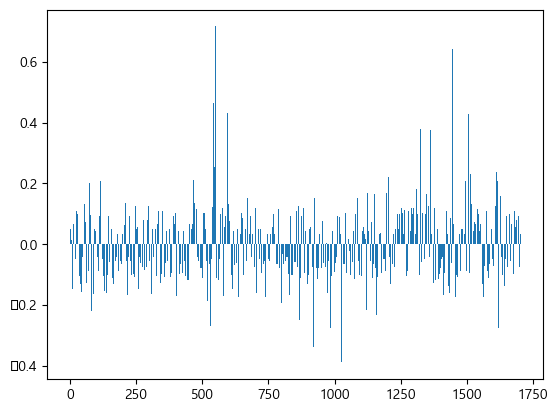

In [51]:
plt.figure()

plt.bar(range(len(logi.coef_.flatten())), logi.coef_.flatten())
plt.show()

In [52]:
# 회귀 모델의 계수를 내림차순으로 정렬
coef_pos_idx = sorted(((value, idx) for idx, value in enumerate(logi.coef_.flatten())), reverse = True)

In [53]:
logi.coef_.flatten()

array([ 0.13628565, -0.09670014,  0.0491595 , ...,  0.09237259,
       -0.15867764,  0.03289955])

In [54]:
coef_pos_idx

[(0.715805240401717, 550),
 (0.6872272669569012, 1380),
 (0.6419495433245718, 1445),
 (0.5728940731338319, 557),
 (0.5557413464304156, 73),
 (0.5284914072179014, 951),
 (0.4638125900212737, 542),
 (0.43233269632965626, 595),
 (0.42904025375565, 1505),
 (0.38475260398946487, 553),
 (0.37734606377535107, 1324),
 (0.37708098782264954, 1362),
 (0.36683013892968935, 1588),
 (0.36473710836227247, 470),
 (0.3646958935596621, 1502),
 (0.3621392651924492, 1391),
 (0.35379862356486375, 1199),
 (0.341750161724604, 1367),
 (0.33799742254248627, 67),
 (0.3375285172637402, 665),
 (0.3228496180580081, 1531),
 (0.30993376780172743, 1601),
 (0.2979000696952396, 454),
 (0.29770011410316183, 1325),
 (0.2922384656877918, 1261),
 (0.2919264081016016, 455),
 (0.2913307412095703, 952),
 (0.28142395367601897, 1097),
 (0.27088728674682067, 42),
 (0.2689129423154866, 1303),
 (0.25736083843901464, 583),
 (0.25262898607732454, 546),
 (0.24801056131994872, 1443),
 (0.24801056131994872, 488),
 (0.24322276023957864,

In [55]:
# 상위 20개 긍정 형태소
for value, idx in coef_pos_idx[:20]:
    print(tfidf.get_feature_names_out()[idx], value)

맛있어요 0.715805240401717
좋아요 0.6872272669569012
진짜 0.6419495433245718
맛있음 0.5728940731338319
갑니다 0.5557413464304156
신촌 0.5284914072179014
맛있는 0.4638125900212737
먹었습니다 0.43233269632965626
추천 0.42904025375565
맛있었어요 0.38475260398946487
쟁반짜장 0.37734606377535107
조금 0.37708098782264954
파이 0.36683013892968935
마늘바게트 0.36473710836227247
최고 0.3646958935596621
좋은 0.3621392651924492
웨이팅이 0.35379862356486375
존맛 0.341750161724604
감사 0.33799742254248627
미쳤어요 0.3375285172637402


In [56]:
# 상위 20개 부정 형태소
for value, idx in coef_pos_idx[:-20:-1]:
    print(tfidf.get_feature_names_out()[idx], value)

무난 -0.38867925552594207
아하 -0.38867925552594207
그냥 -0.3771399648151579
없음 -0.354237114162564
가게 -0.34452948373926456
시끄러움 -0.3379012401339706
굳이 -0.3306124094759467
맛이 -0.3229314537226864
갈비탕 -0.3178080737713316
갔는데 -0.3133974234683808
아까움 -0.2748377372889325
하나도 -0.2748377372889325
맛은 -0.2702237756826561
인분 -0.26931156301693904
가지마 -0.2576321432376288
실망이 -0.25604483754890756
크네요 -0.25604483754890756
여기가 -0.25535786750748724
서비스 -0.2490740041799796
